### Objective

[ArcFace](https://arxiv.org/abs/1801.07698)에서 Angular Margin Loss를 통해, MNIST 데이터가 어떤 식으로 임베딩 되는지를 확인하기 위함

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

np.set_printoptions(3)

## 예제 데이터 : MNIST

MNIST 숫자는 (28,28)의 크기를 가진 행렬입니다. arcface를 통한 숫자 임베딩해 보도록 하겠습니다. 일반적인 Image Classification 모델에 `ARCFACE`라 불리는 Layer를 추가하는 것이 특징입니다.

### 데이터셋 가져오기

In [2]:
from tensorflow.keras.datasets import mnist

trainset, testset = mnist.load_data()

train_images, train_labels = trainset
test_images, test_labels = testset

### 데이터 시각화

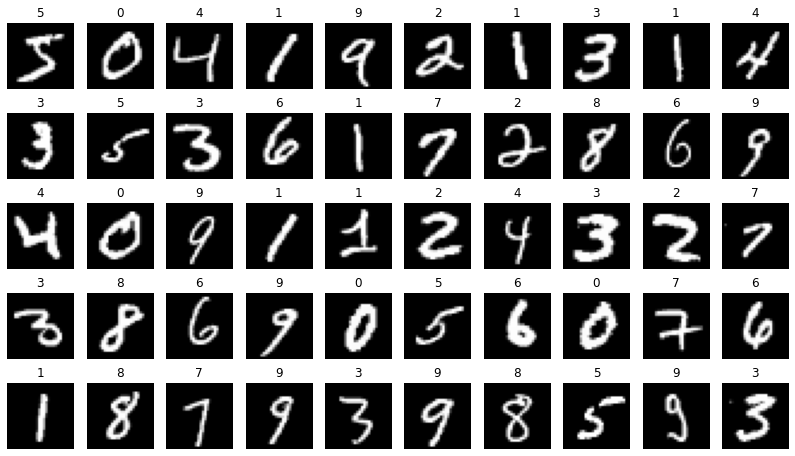

In [3]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        ax = plt.subplot(n_rows, n_cols, index + 1)
        ax.set_title(train_labels[index])
        ax.imshow(train_images[index], cmap="gray")
        plt.axis('off')
plt.show()

## ARCFACE 구현하기

### CNN 모형 구성하기


In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from functools import partial

# Conv2D Default 세팅값 변경
Conv2D = partial(Conv2D, kernel_size=(3,3), 
                 kernel_regularizer=l2(1e-4),
                 activation='relu', padding='same')

inputs = Input(shape=(28,28,1), name='images')

conv = Conv2D(16, name='conv1_1')(inputs)
conv = BatchNormalization(name='bn1_1')(conv)
conv = Conv2D(16, name='conv1_2')(conv)
conv = BatchNormalization(name='bn1_2')(conv)
pool = MaxPooling2D(name='pool1')(conv)

conv = Conv2D(32, name='conv2_1')(pool)
conv = BatchNormalization(name='bn2_1')(conv)
conv = Conv2D(32, name='conv2_2')(conv)
conv = BatchNormalization(name='bn2_2')(conv)
pool = MaxPooling2D(name='pool2')(conv)

conv = Conv2D(64, name='conv3_1')(pool)
conv = BatchNormalization(name='bn3_1')(conv)
conv = Conv2D(64, name='conv3_2')(conv)
conv = BatchNormalization(name='bn3_2')(conv)
pool = MaxPooling2D(name='pool3')(conv)

이 때 convolution의 출력을 `Flatten`을 통해 1차원으로 바꾸어 준 후, 유닛의 갯수가 3개인 `Dense`를 통과해 줍니다. 이를 통해 우리는 (28,28)의 이미지를 3개의 숫자로 표현하는 임베딩 모델을 구성하였습니다.

In [5]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

num_embed = 2

x = BatchNormalization()(pool)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(num_embed, use_bias=False,
          kernel_regularizer=l2(1e-4), name='embed')(x)
x = BatchNormalization()(x)

### ARCFace Layer 구성하기


![Imgur](https://i.imgur.com/lOFkd8W.png)

$$
softmax_{arcface} = -\frac{1}{N}\sum^{N}_{i=1} log \frac{e^{s(cos(\theta_{y_i}+m))}}{e^{s(cos(\theta_{y_i} + m))+ \sum_{j\neq y_i} e^{s(cos(\theta_{y_j}))}}}
$$

#### - 각 클래스 별 기준 Vector 구하기

각 클래스 별로 기준 벡터를 둡니다. A 클래스에 해당하는 이미지의 임베딩 벡터는 A 기준 벡터와 유사하도록, B 클래스에 해당하는 이미지의 임베딩 벡터는 B 기준 벡터와 매우 유사하도록 학습할 예정입니다. 

In [6]:
num_classes = 10

# 임의로 만들 기준 벡터
weights = np.random.normal(0, 1., size=(num_embed, num_classes))

#### - 두 벡터의 유사도를 계산하는 방법 : Cosine Similarity

두 벡터의 유사성을 계산하는 방법에는 크게 거리를 기반한 방법과 각도를 기반한 방법이 존재합니다.<br>
각도를 기반한 유사성을 구할 때에 주로 사용하는 것은 바로 `Cosine Similarity`입니다.


$$
similarity(A,B) = cos(\theta) = \frac{A\cdot B}{|A| |B|}
$$

In [7]:
import tensorflow as tf

def cosine_similarity(a, b):
    return tf.matmul(a, b) / (
        tf.linalg.norm(a, axis=1) * tf.linalg.norm(b, axis=0))

cosine_similarity(x, weights.astype(np.float32))

<tf.Tensor 'RealDiv:0' shape=(None, 10) dtype=float32>

해당 모델의 출력값은 총 10개가 나오는데, 이는 0부터 9까지의 라벨에 대한 유사도를 의미합니다.<br0>
이미지의 임베딩 값이 $E_{image}$이고, 각 클래스에 대한 Weight 값은 $[W_{0}, W_{1}, W_{2}, \cdots, W_{9}]$라고 합니다.

#### - 보다 효과적으로 구별짓게 만드는 조건, Margin

각 Class 별로 각도 차이가 크게 나는 방향으로 학습하도록, Margin 제약을 주게 됩니다. 

$$
softmax_{arcface} = -\frac{1}{N}\sum^{N}_{i=1} log \frac{e^{s(cos(\theta_{y_i}+m))}}{e^{s(cos(\theta_{y_i} + m))+ \sum_{j\neq y_i} e^{s(cos(\theta_{y_j}))}}}
$$

이렇게 되면 어떻게 될까요? Margin이 0.5이라고 해봅시다. 모델이 완벽하게 학습이 되어서 타겟 클래스와의 유사도가 1로, $theta=0$이 되더라도, Margin이 붙기 때문에 유사도는 $cos(0+m) = cos(0.5)$가 됩니다.<br>
그렇다면 다른 클래스와의 유사도(cos(0.5))보다 더 떨어져야지, 정확하게 분류할 수 있습니다.<br>
이렇듯 Margin은 모델이 좀 더 완벽하게 구별하는 방향으로 강제합니다.

#### - ArcFace 구성하기

ArcFace는 기존 Softmax의 연산에 cosine Similarity와 Margin 연산만 추가하면 됩니다.<br>
ArcFace는 scale와 margin에 매우 민감합니다. 해당 hyper-parameter들은 데이터의 상황에 따라 다르게 결정되어야 합니다. 

In [8]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class ArcFace(Layer):
    def __init__(self, num_classes, 
                 scale=64, margin=0.5, **kwargs):
        self.num_classes = num_classes
        self.scale = scale
        self.margin = margin
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        self.w = self.add_weight(
            name='weight', trainable=True,
            shape=(input_shape[0][-1], self.num_classes))
        super().build(input_shape)
    
    @tf.function
    def call(self, inputs):
        assert isinstance(inputs, list) or isinstance(inputs, tuple)
        # Last Convolution Layers output and Ground Truth Label
        features, labels = inputs
        
        # (1) 각 클래스 별로 코사인 유사도 구하기
        norm_feat = tf.linalg.l2_normalize(features, axis=1)
        norm_weight = tf.linalg.l2_normalize(self.w, axis=0)
        cosine = norm_feat @ norm_weight
        # 이미지와 특정 클래스와의 유사도가 높을수록 해당 값이 1에 가까워지고
        # 낮을 수록 -1에 가까워짐
        
        # (2) acos을 통해 theta값 구하기
        # acos란? cosine의 역함수.
        # 주의할 점 : 
        # acos은 -1.~1.값 범위 외 input이 들어올 시 NaN 값 반환하기 때문에
        # 값의 범위를 잡아주어야 함.
        # acos의 출력값 0:~np.pi
        cosine = tf.clip_by_value(cosine, -1.+1e-7, 1.-1e-7) 
        theta = tf.math.acos(cosine)
        
        # (3) GT Class에 해당하는 Theta에만 Margin을 부여
        one_hot = tf.one_hot(labels, self.num_classes,
                             True, False, axis=-1) 
        margin_theta = tf.where(one_hot, theta + self.margin, theta)
        margin_theta = tf.clip_by_value(margin_theta, 0., np.pi)
        
        # (4) Cosine 값으로 복원 후, Scaling (보통 64)
        logits = self.scale * tf.math.cos(margin_theta)
        return logits
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "scale": self.scale,
            "margin": self.margin
        })
        return config

In [9]:
num_classes = 10
scale = 30
margin = 0.5

# 해당 이미지가 어떤 클래스인지 알려줌으로써
# 대상 클래스에 대한 Margin만 추가
labels = Input(shape=(), dtype=tf.int32, name='labels')
outputs = ArcFace(num_classes, scale, margin)([x, labels])

정리하면 아래와 같습니다.

In [10]:
from tensorflow.keras.models import Model

model = Model([inputs, labels], outputs)

### 모델 학습시키기

#### 모델 컴파일하기

In [11]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy

optimizer = Adam()
loss = SparseCategoricalCrossentropy(from_logits=True)
metrics = [SparseCategoricalAccuracy()]

model.compile(optimizer, loss, metrics)

#### 데이터 파이프라인 구성하기

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

traingen = ImageDataGenerator(rescale=1/255.)
validgen = ImageDataGenerator(rescale=1/255.)

trainset = traingen.flow(
    (train_images[...,None], train_labels), train_labels, batch_size=128)
validset = validgen.flow(
    (test_images[...,None], test_labels), test_labels, batch_size=128)

#### 모델 학습시키기

In [ ]:
model.fit(trainset, validation_data=validset, epochs=10)

## 임베딩 시각화하기

### 임베딩 결과를 반환하는 모델 구성하기

In [19]:
infer_model = Model(inputs, x)

infer_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 28, 28, 16)        160       
_________________________________________________________________
bn1_1 (BatchNormalization)   (None, 28, 28, 16)        64        
_________________________________________________________________
conv1_2 (Conv2D)             (None, 28, 28, 16)        2320      
_________________________________________________________________
bn1_2 (BatchNormalization)   (None, 28, 28, 16)        64        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 14, 14, 32)        4640

### 이미지에 대한 임베딩 결과 가져오기

In [20]:
test_embeds = infer_model.predict(test_images[...,None]/255.)

각 이미지 별로 임베딩 결과는 아래와 같습니다.

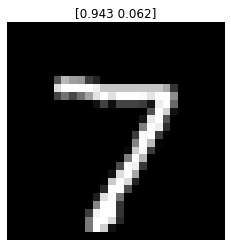

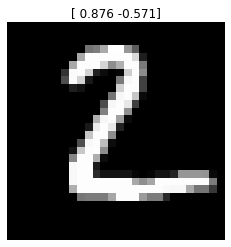

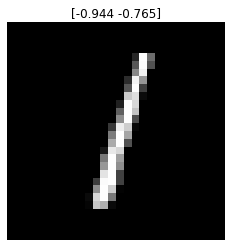

In [21]:
for image, embedding_value in zip(test_images, test_embeds[:3]):
    plt.title(str(embedding_value))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

### 임베딩 분포도 시각화하기

Softmax를 통해 임베딩 했을 때와는 매우 다른 형상을 띕니다. 같은 이미지끼리는 특정 각도를 기준으로 가까이 모여 있는 것을 확인할 수 있습니다. 

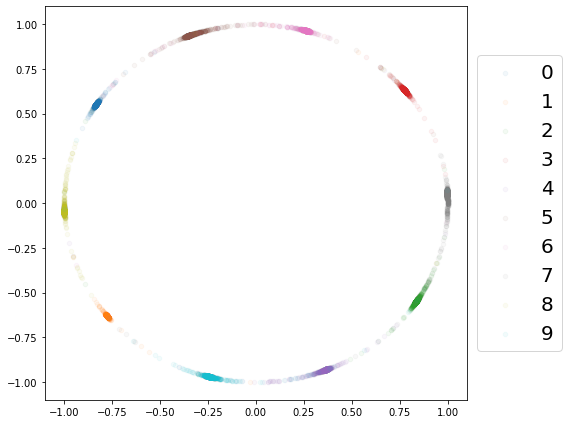

In [22]:
norm_embeds = (
    test_embeds / np.linalg.norm(test_embeds,axis=1,keepdims=True))

fig = plt.figure(figsize=(8,6))
for c in range(len(np.unique(test_labels))):
    plt.scatter(norm_embeds[test_labels==c, 0], 
                norm_embeds[test_labels==c, 1],  
                s=20,alpha=0.05, label=c)

plt.legend(fontsize=20, 
           loc='center left', 
           bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()